                           Date     Open     High      Low    Close  \
274  2018-10-02 00:00:00.000000  6593.24  6611.84  6537.90  6556.10   
275  2018-10-03 00:00:00.000000  6553.86  6571.46  6454.03  6502.59   
276  2018-10-04 00:00:00.000000  6497.91  6603.31  6497.91  6576.69   
277  2018-10-05 00:00:00.000000  6574.15  6623.62  6557.41  6622.48   
278  2018-10-06 00:00:00.000000  6622.45  6628.54  6577.80  6588.31   

         Volume    Market Cap  year  month  day         YMD  pos_chg_1  \
274  3979260000  114062551875  2018     10    2  2018-10-02          0   
275  3887310000  113392236466  2018     10    3  2018-10-03          0   
276  3838410000  112435991226  2018     10    4  2018-10-04          0   
277  3671500000  113767335788  2018     10    5  2018-10-05          0   
278  3259740000  114614282649  2018     10    6  2018-10-06          0   

     pos_chg_2  pos_chg_3  pct_return1_1  pct_return1_2  pct_return1_3  
274          0          0       0.480047       0.770608

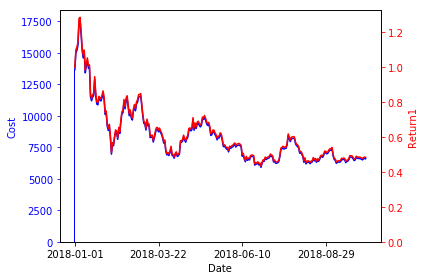

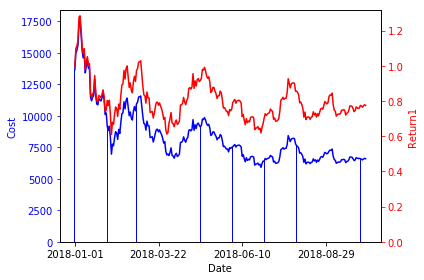

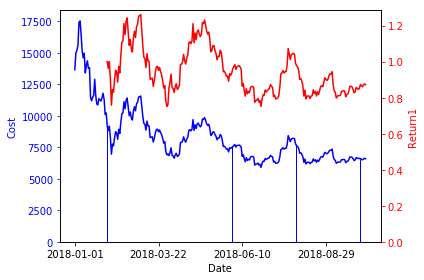

(0, 1.3259070673344462)

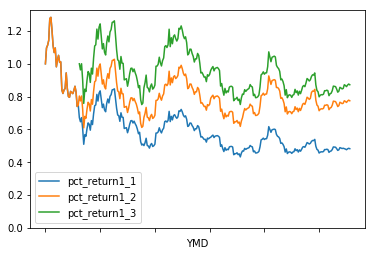

In [4]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
#import seaborn as sns; sns.set()

#------------------------------
#-- 0. Read in Asset_Daily   --
#------------------------------

df = pd.read_csv('BTC.csv')

#-----------------------
#-- 1. Pre-Processing --
#-----------------------
# need to convert text to date
# ref code: raw_data['Mycol'] = pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df['year'] = pd.DatetimeIndex(df['Date']).year # https://erikrood.com/Python_References/extract_month_year_pandas_final.html
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
#df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M') # still object
#df['YMD'] = pd.to_datetime(df['Date']).dt.to_period('D') # still object
df = df.set_index('Date') # need to have df = in the front... do I have to sort it?
df.sort_index(inplace=True)

#-----------------------
#-- 2. Strategy File  --
#-----------------------

q = """SELECT 
      df.*
     ,(year || '-' || substr('00'||month, -2, 2) || '-' || substr('00'||day, -2, 2)) as YMD
     ,case 
        when Date = '2018-01-01 00:00:00.000000' then 1 else 0 
      end as pos_chg_1
     ,case 
        when day = 1 then 1 else 0
      end as pos_chg_2
     ,case 
        when (day = 1 AND month in (2,4,6,8,10)) then 1 else 0
      end as pos_chg_3
    FROM
      df
    WHERE
      Date >= '2018-01-01'
    ;"""
df = pysqldf(q)

#-----------------------
#-- 3. Return File    --
#-----------------------

## market value
# df['cum_pos'] = df['pos_chg'].cumsum()
# df['market_value'] = df['cum_pos']*df['Close']

## cost
# df['cost'] = df['pos_chg']*df['Close']
# df['cum_cost'] = df['cost'].cumsum()

## return of 1
# df['pct_return1'] = df['market_value']/df['cum_cost']
#df['pct_return1'] = (df['pos_chg'].cumsum() * df['Close']) / (df['pos_chg']*df['Close']).cumsum()

def get_return1(sid):
    pct_return1 = 'pct_return1_' + str(sid)
    pos_chg = 'pos_chg_' + str(sid)
    df[pct_return1] = (df[pos_chg].cumsum() * df['Close']) / (df[pos_chg]*df['Close']).cumsum()
    return df

get_return1(1)
get_return1(2)
get_return1(3)
print(df.tail())

#-----------------------
#-- 4. Visualization  --
#-----------------------

def get_chart(sid):
    pct_return1 = 'pct_return1_' + str(sid)
    pos_chg = 'pos_chg_' + str(sid)

    x1 = df['YMD']
    y1 = df[pos_chg]*df['Close']
    y2 = df['Close']
    y3 = df[pct_return1]

    fig, ax1 = plt.subplots()

    ax1.bar(x1, y1, color='b') # cost
    ax1.plot(x1, y2, color='b') # price
    ax1.set_xlabel('Date')

    ### Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cost', color='b')
    ax1.tick_params('y', colors='b')

    ### Twin axis
    ax2 = ax1.twinx()
    ax2.plot(x1, y3, color='r')
    ax2.set_ylim([0,None])
    ax2.set_ylabel('Return1', color='r')
    ax2.tick_params('y', colors='r')

    #plt.title('strategy return')
    plt.xticks(x1)

    ### set max n ticks
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))

    plt.tight_layout()
    plt.show()
    
get_chart(1)
get_chart(2)
get_chart(3)

### compare strategies ###
ax = df[["YMD", "pct_return1_1", "pct_return1_2", "pct_return1_3"]].plot(x="YMD")
ax.set_ylim([0,None])